In [53]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.applications import EfficientNetV2B0
from keras import regularizers

In [54]:
img_size = (224, 224)

# train data
cwd = os.getcwd()
epochs = 50
df = pd.read_csv(cwd + '/augmentation_data.csv')
X = list(df['image'][i] for i in range(len(df)))
y = list(df['emotion'][i] for i in range(len(df)))

In [55]:
weight = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)))
print(weight)

{0: 0.970107056694813, 1: 1.0951685201997277, 2: 0.995731015270326, 3: 0.964869526094781, 4: 0.96496600339966, 5: 0.96496600339966, 6: 0.96496600339966, 7: 1.1031807270233196}


In [56]:
def create_model():
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(img_size[0], img_size[1], 3)),
        layers.experimental.preprocessing.RandomRotation(
            0.05, fill_mode='nearest'
        ),

        EfficientNetV2B0(
            include_top=False, weights='imagenet', input_tensor=None,
            input_shape=(img_size[0], img_size[1], 3), include_preprocessing=True
        ),

        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Flatten(),


        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(8, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True),  # tf.keras.optimizers.Adam(amsgrad=True),  # tf.keras.optimizers.SGD(nesterov=True), # tfa.optimizers.RectifiedAdam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])

    return model

In [57]:
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy', patience=epochs*0.05, restore_best_weights=True)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath="model/cp-{epoch:04d}.ckpt",
#     verbose=0,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     save_best_only=True)
# tb_callback = tf.keras.callbacks.TensorBoard(
#     log_dir="./logs",
#             update_freq="epoch")

In [58]:
model = create_model()
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_5 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               655872    
                                                      

In [59]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
# adam=Adam(lr=0.001)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])


In [60]:
import os, cv2, shutil
df_train = pd.read_csv(cwd + "\\state\\train.csv")
df_val = pd.read_csv(cwd + "\\state\\val.csv")
output_train_dir = cwd + "\\train"
root_image_dir = cwd + "\\..\\cleaned_images\\"
dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']
dir_test = cwd + "\\test\\"
dir_train = cwd + "\\train\\"
if(os.path.exists(dir_train) or os.path.exists(dir_test)):
    shutil.rmtree(dir_train)
    shutil.rmtree(dir_test)
for emotion in dictionary:
    os.makedirs(dir_test + "\\" + emotion)
    os.makedirs(dir_train + "\\" + emotion)

def isInDir(image_dir):
    return len(image_dir.split("/")) >= 2
for index, row in df_val.iterrows():
    if(isInDir(row['image']) == False): 
        output_test_dir = dir_test + dictionary[row['emotion']] + "\\" + row['image']
    else:
        output_test_dir = dir_test + row['image']
    image = cv2.imread(root_image_dir + row['image'])
    cv2.imwrite(output_test_dir, image)
for index, row in df_train.iterrows():
    if(isInDir(row['image']) == False):
        output_train_dir = dir_train + dictionary[row['emotion']] + "\\" + row['image']
    else:
        output_train_dir = dir_train + row['image']
    image = cv2.imread(root_image_dir + row['image'])
    cv2.imwrite(output_train_dir, image)


In [61]:
bs = 150
train_dir = cwd + "\\train"
test_dir = cwd + "\\test"
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=bs,class_mode='categorical',target_size=(img_size[0],img_size[1]))
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=bs,
                                                         class_mode  = 'categorical',
                                                         target_size=(img_size[0],img_size[1]))
dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    class_names=dictionary,
    color_mode='rgb',
    batch_size=bs)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    class_names=dictionary,
    color_mode='rgb',
    batch_size=bs)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Found 26974 images belonging to 8 classes.
Found 3331 images belonging to 8 classes.
Found 26974 files belonging to 8 classes.
Found 3331 files belonging to 8 classes.


In [62]:
'''
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=epochs*0.1, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model/cp-{epoch:04d}.ckpt",
    verbose=0,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir="./logs",
            update_freq="epoch")
'''

'\nes_callback = tf.keras.callbacks.EarlyStopping(\n    monitor=\'val_accuracy\', patience=epochs*0.1, restore_best_weights=True)\ncp_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath="model/cp-{epoch:04d}.ckpt",\n    verbose=0,\n    save_weights_only=True,\n    monitor=\'val_accuracy\',\n    save_best_only=True)\ntb_callback = tf.keras.callbacks.TensorBoard(\n    log_dir="./logs",\n            update_freq="epoch")\n'

In [63]:
history = model.fit(train_ds, validation_data=val_ds, shuffle=True, epochs=epochs, #callbacks=[es_callback, cp_callback, tb_callback
                                                                                                   #, reduce_lr
                                                                                                  #],
                                                                                                  class_weight=weight, batch_size=bs)

Epoch 1/50


c:\Users\thanapat\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


180/180 [==============================] - 2480s 14s/step - loss: 9.9708 - accuracy: 0.4358 - val_loss: 5.5608 - val_accuracy: 0.6220
Epoch 2/50
180/180 [==============================] - 2429s 13s/step - loss: 3.6295 - accuracy: 0.6445 - val_loss: 2.3320 - val_accuracy: 0.6587
Epoch 3/50
180/180 [==============================] - 2444s 14s/step - loss: 1.6980 - accuracy: 0.7043 - val_loss: 1.3556 - val_accuracy: 0.7040
Epoch 4/50
180/180 [==============================] - 2482s 14s/step - loss: 1.1204 - accuracy: 0.7381 - val_loss: 1.0628 - val_accuracy: 0.7292
Epoch 5/50
180/180 [==============================] - 2447s 14s/step - loss: 0.9095 - accuracy: 0.7637 - val_loss: 1.1275 - val_accuracy: 0.6905
Epoch 6/50
180/180 [==============================] - 2472s 14s/step - loss: 0.8092 - accuracy: 0.7872 - val_loss: 1.0901 - val_accuracy: 0.7016
Epoch 7/50
180/180 [==============================] - 2475s 14s/step - loss: 0.7359 - accuracy: 0.8056 - val_loss: 1.0698 - val_accuracy: 0.6

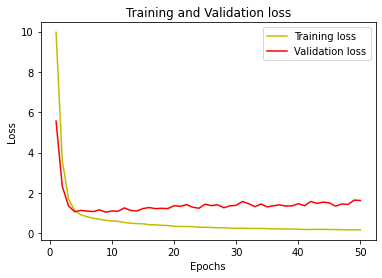

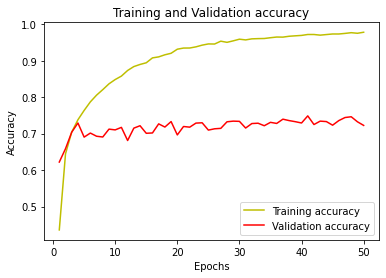

In [64]:
import matplotlib.pyplot as plt
#Plotting the training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [67]:

print(train_ds)
print('---------------')
print(val_ds)
print('---------------')


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
---------------
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
---------------


In [68]:
cwd = os.getcwd()
n_df = pd.read_csv(cwd + "/state/val.csv")

In [69]:
n_df

,image,emotion
0,CONTEMPT/contempt (1914)_4652.jpg,1
1,NEUTRAL/Sharess_Harrell_0001_4341.jpg,5
2,SADNESS/sadness (2492)_5998.jpg,6
3,SURPRISE/Nathan_Lane_0001_2689.jpg,7
4,HAPPINESS/Andre_Agassi_0015_9167.jpg,4
...,...,...
13892,HAPPINESS/Adrien_Brody_0007_8725.jpg,4
13893,HAPPINESS/Abdullah_Gul_0012_8691.jpg,4
13894,SURPRISE/surprise (324)_5132.jpg,7
13895,ANGER/anger (1933)_4250.jpg,0


In [ ]:
for idx, row in df.iterrows():
    imagePath = cwd + "/cleaned_images/" + row.image
    image = cv2.imread(imagePath)

emo_feature = list(row.emotion for idx, row in df.iterrows())

c:\Users\thanapat\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


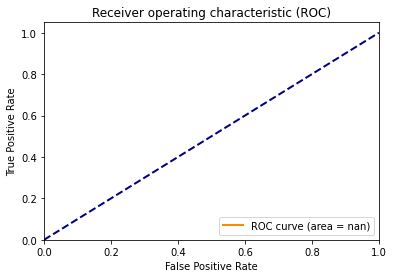

In [65]:

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for idx in range(len(dictionary)):
    print(dictionary[idx])

    emo_feature = np.copy(X_train)
    emo_target = list(label[idx] for label in y_train)
    emo_target = np.array(emo_target)

    X = emo_feature
    y = emo_target

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train, val) in enumerate(cv.split(X, y)):
        X_train_kf, X_val_kf = X[train], X[val]
        y_train_kf, y_val_kf = y[train], y[val]

        le = preprocessing.LabelEncoder()
        y_train_kf = to_categorical(y_train_kf)
        y_val_kf = to_categorical(y_val_kf)

        model = create_model_best_param(best_params, 2)
        model.fit(X_train_kf,
                    y_train_kf,
                    validation_data=(X_val_kf, y_val_kf,),
                    batch_size=best_params['batch_size'],
                    epochs=best_params["epochs"],
                    verbose=2)

        # predict
        y_pred = model.predict(X_val_kf).ravel()
        y_val_kf = y_val_kf.ravel()

        print('====================Fold ', i , '====================')

        # plot ROC curve
        viz = RocCurveDisplay.from_predictions(y_val_kf, y_pred, ax=ax, name="ROC fold {}".format(i), alpha=0.3, lw=1,)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(cwd + '/../graph/' + dictionary[idx] + '/ann_relu.jpg')
    plt.show()

In [66]:
# test model
# Confution Matrix and Classification Report

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

Y_pred = model.predict_generator(validation_generator, steps = nb_samples // bs)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=dictionary))


C:\Users\thanapat\AppData\Local\Temp\ipykernel_32524\4232138718.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, steps = nb_samples // bs)


Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [3331, 3300]